# Tutorial de Flujo de trabajo con señal EEG
# Extras.

Este notebook adicional se basará en aplicar lo que hemos revisado en el anterior notebook pero a más de 1 participante.
<br><br>
Para ello, utilizaremos dos participantes de la esta [base de datos](https://www.mdpi.com/2306-5729/8/6/95). El código está para procesar información de 2 a más participantes; sólo estamos utilizando 2 por las limitaciones de almacenamiento de la máquina virtual.
<br><br>
Además, como son los mismos scripts que el notebook anterior, podemos obviar repetir las mismas explicaciones y saltar a los análisis.
<br><br>
¡Veamos qué sucede!

In [1]:
%%capture
!pip install openneuro-py
!pip install mne
!pip install mne-bids
!pip install autoreject
!pip install bids
!pip install mne-icalabel

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import openneuro as on
import mne
from mne_bids import BIDSPath, read_raw_bids
from bids import BIDSLayout
from autoreject import AutoReject
from mne.preprocessing import ICA
from mne_icalabel import label_components

In [3]:
!mkdir data

In [4]:
on.download(
    dataset="ds004504",
    target_dir="/content/data",
    include=["sub-001/", "sub-002/"],  # incluimos dos participantes esta vez.
)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds004504 …


📁 Traversing directories for ds004504 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 11 files (5 concurrent downloads). 
✅ Finished downloading ds004504.
 
🧠 Please enjoy your brains.
 


In [5]:
!ls /content/data

CHANGES  dataset_description.json  participants.json  participants.tsv	README	sub-001  sub-002


In [6]:
layout = BIDSLayout("/content/data/")
subjects = layout.get_subjects()
subjects.sort()

In [7]:
subjects  # podemos revisar los dos participantes

['001', '002']

Utilizamos `get_tasks` para obtener el nombre de la tarea que le asignaron a la tarea ejecutada en el paper. Recordemos que en el anterior ejemplo esta tarea se llamaba 'kickstarter'. Esto lo realizaremos para poder reemplazar 'kickstarter' en nuestro código por la tarea actual.

In [8]:
layout.get_tasks()

['eyesclosed']



Antes de ejecutar todos los códigos juntos para obtener las epochs filtradas, crearemos un diccionario para guardar la información de los participantes.
<br><br>
Dentro de este diccionario, cada key será un participante y el valor de la key el objeto epochs correspondiente.

In [9]:
epochs_eeg = {}

¡Muy bien! Sin embargo, antes de seguir ¿No estaremos olvidando algo importante 「(°ヘ°)?
<br><br>
¡Los eventos! Hay que recordar que las epochs son segmentos o cortes de la señal. En el notebook anterior, los eventos nos servían como guía para hacer los segmentos alrededor de ellos, pero en esta base de datos no tenemos eventos... porque el paper sólo consiste en explorar la frecuencia de descanso en pacientes con Alzheimer y otras enfermedades.
<br><br>
Entonces ¿Cómo se harán los segmentos? ¡Fácil! En vez de cortar la señal alrededor de los eventos, la cortaremos en intervalos fijos con la función `mne.make_fixed_length_epochs`. Dentro indicaremos en los parámetros que los segmentos serán de 4 segundos con una superposición de 500 ms. Así mismo, utilizaremos todos los filtrados aprendidos dentro de un loop que iterara entre los dos valores que tenemos en la variable `subjects` que hemos creado anteriormente.


In [28]:
print(
    list(enumerate(subjects))
)  # podemos ver cómo funciona enumerate internamente. Devuelve una lista de tuplas.

[(0, '001'), (1, '002')]


In [17]:
for i, sub in enumerate(subjects):

    bids_path = BIDSPath(
        root="/content/data", subject=sub, task="eyesclosed", datatype="eeg"
    )

    raw = read_raw_bids(bids_path, verbose=False, extra_params={"preload": True})

    raw.filter(l_freq=1, h_freq=100.0)

    raw.set_eeg_reference(ref_channels="average")

    epochs = mne.make_fixed_length_epochs(raw, duration=4, overlap=0.5, preload=True)

    # Autoreject
    # crea el modelo de rechazo
    ar = AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, n_jobs=1, verbose=True)
    # ajusta el modelo a los epochs para aprender e identificar artefactos
    ar.fit(epochs[:20])
    # aplica el modelo y devuelve tantos los epochs limpios como rechazados
    epochs_ar, reject_log = ar.transform(epochs, return_log=True)
    # actualiza las epochs con las nuevas epochs reparadas y filtradas
    epochs = epochs_ar

    # epochs = epochs[~reject_log.bad_epochs] #si solo se quieren filtrar las epochs rechazadas y no utilizar las mejoradas.

    ica = ICA(
        max_iter="auto",  # max_iter="auto",
        method="infomax",
        random_state=99,
        fit_params=dict(extended=True),
    )
    ica.fit(epochs[:50])

    ic_labels = label_components(epochs, ica, method="iclabel")
    labels = ic_labels["labels"]

    exclude_idx = [
        idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
    ]
    if not exclude_idx:
        print("No ICA components found to exclude.")
    else:
        print(f"Excluding these ICA components: {exclude_idx}")
        ica.apply(epochs, exclude=exclude_idx)

    epochs_eeg[sub] = epochs

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1651 samples (3.302 s)



<ipython-input-17-a0a8958aeb41>:10: RuntimeWarning: Did not find any events.tsv associated with sub-001_task-eyesclosed.

The search_str was "/content/data/sub-001/**/eeg/sub-001*events.tsv"
  raw = read_raw_bids(
<ipython-input-17-a0a8958aeb41>:10: RuntimeWarning: Unable to map the following column(s) to to MNE:
Gender: F
Age: 57
Group: A
MMSE: 16
  raw = read_raw_bids(


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
171 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 171 events and 2000 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=2


  0%|          | Repairing epochs : 0/171 [00:00<?,       ?it/s]

Dropped 6 epochs: 6, 20, 128, 129, 151, 152
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 19 components
Computing Extended Infomax ICA
Fitting ICA took 35.1s.
Excluding these ICA components: [0, 1, 4, 5, 6, 8, 10, 12, 13, 14, 15, 17]
Applying ICA to Epochs instance
    Transforming to ICA space (19 components)
    Zeroing out 12 ICA components
    Projecting back using 19 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter le

<ipython-input-17-a0a8958aeb41>:10: RuntimeWarning: Did not find any events.tsv associated with sub-002_task-eyesclosed.

The search_str was "/content/data/sub-002/**/eeg/sub-002*events.tsv"
  raw = read_raw_bids(
<ipython-input-17-a0a8958aeb41>:10: RuntimeWarning: Unable to map the following column(s) to to MNE:
Gender: F
Age: 78
Group: A
MMSE: 22
  raw = read_raw_bids(


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
226 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 226 events and 2000 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/19 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/19 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/4 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/20 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=3


  0%|          | Repairing epochs : 0/226 [00:00<?,       ?it/s]

Dropped 7 epochs: 102, 160, 166, 183, 184, 203, 204
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 19 components
Computing Extended Infomax ICA
Fitting ICA took 47.1s.
Excluding these ICA components: [6, 8, 12, 13, 15, 16]
Applying ICA to Epochs instance
    Transforming to ICA space (19 components)
    Zeroing out 6 ICA components
    Projecting back using 19 PCA components


¡Excelente (へへ)! ahora deberíamos tener dentro del diccionario los dos participantes con sus epochs.

In [18]:
epochs_eeg

{'001': <Epochs | 165 events (all good), 0 – 3.998 s (baseline off), ~47.9 MB, data loaded,
  '1': 165>,
 '002': <Epochs | 219 events (all good), 0 – 3.998 s (baseline off), ~63.5 MB, data loaded,
  '1': 219>}

Lo próximo sería crear objetos evoked con dichas epochs. Recordemos que los objetos evoked son un promedio de epochs. Entonces, deberíamos promediar las epochs que tenemos en cada participante, para lo cual utilizaremos un for loop y guardaremos el resultado en una lista.

In [19]:
evoked_list = []
for (
    participant,
    epochs,
) in (
    epochs_eeg.items()
):  # extraemos los datos del diccionario. Estos siempre vienen en tuplas de: llave-valor. Asignamos el nombre participant a la llave y epochs al valor o contenido de esa llave.
    evoked = epochs_eeg[
        participant
    ].average()  # epochs_eeg[participant] nos permite acceder al contenido de esa llave. Luego al contenido se le da .average()
    evoked_list.append(evoked)  # se agrega a la lista creada.

In [20]:
evoked_list

[<Evoked | '1' (average, N=165), 0 – 3.998 s, baseline off, 19 ch, ~329 kB>,
 <Evoked | '1' (average, N=219), 0 – 3.998 s, baseline off, 19 ch, ~329 kB>]

¡Bien! Ahora si queremos acceder a los evoked y hacer, por ejemplo, plots de estas como en el notebook anterior, sólo tenemos que acceder al índice de la evoked correspondiente en la lista.

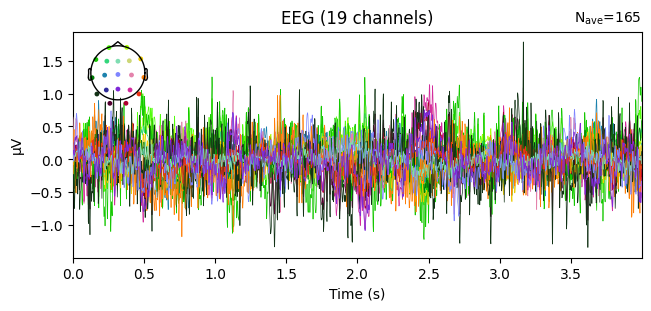

In [22]:
evoked_plot = evoked_list[0].plot()

¡Bien! Ahora ¿Qué pasaría si quiero promediar los dos objetos evoked que tengo?
<br><br>
(・ヘ・)? En teoría se podría ¿Verdad?
<br><br>
¡Pues sí!, para eso, podemos utilizar la función `mne.grand_average`. Esto será útil dependiendo del objetivo de nuestro estudio. En esta ocasión, colocaremos dentro de grand_average la lista de evokeds que tenemos.



In [24]:
grand_average = mne.grand_average(evoked_list)

Identifying common channels ...


¡Genial! Ahora podemos realizar todos los análisis que realizamos antes con un objeto evoked. La diferencia ahora es que este objeto evoked, en este contexto, contiene información de tooodos los participantes (bueno, en este caso un par), ¡Así que los gráficos y los datos en estos objetos serán más informativos! (へへ)✌

    Using multitaper spectrum estimation with 7 DPSS windows


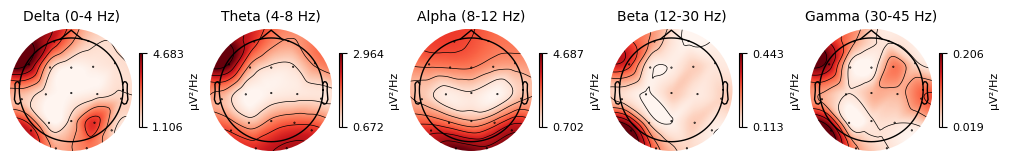

In [25]:
grand_average_plot = grand_average.compute_psd().plot_topomap()

# Elaborado por

*   Daniel Falcón Quintana
*   Miguel Dávila Palomino
<br><br>

# Referencias:

Andreas Miltiadous and Katerina D. Tzimourta and Theodora Afrantou and Panagiotis Ioannidis and Nikolaos Grigoriadis and Dimitrios G. Tsalikakis and Pantelis Angelidis and Markos G. Tsipouras and Evripidis Glavas and Nikolaos Giannakeas and Alexandros T. Tzallas (2024). A dataset of EEG recordings from: Alzheimer's disease, Frontotemporal dementia and Healthy subjects. OpenNeuro. [Dataset] doi: doi:10.18112/openneuro.ds004504.v1.0.8

Delorme, A. (2023). EEG is better left alone. Scientific reports, 13(1), 2372. https://doi.org/10.1038/s41598-023-27528-0

Gorgolewski, K. J., Auer, T., Calhoun, V. D., Craddock, R. C., Das, S., Duff, E. P., ... & Poldrack, R. A. (2016). The brain imaging data structure, a format for organizing and describing outputs of neuroimaging experiments. Scientific data, 3(1), 1-9. https://doi.org/10.1038/sdata.2016.44

Hoechenberger, A. (2023). openneuro-py. GitHub. https://github.com/hoechenberger/openneuro-py

Jas, M., Engemann, D., Raimondo, F., Bekhti, Y., & Gramfort, A. (2016). Automated rejection and repair of bad trials in MEG/EEG. En 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI).

Jas, M., Engemann, D., Bekhti, Y., Raimondo, F., & Gramfort, A. (2017). Autoreject: Automated artifact rejection for MEG and EEG data. NeuroImage, 159, 417-429. https://doi.org/10.1016/j.neuroimage.2017.06.030

Larson, E., Gramfort, A., Engemann, D. A., Leppakangas, J., Brodbeck, C., Jas, M., Brooks, T. L., Sassenhagen, J., McCloy, D., Luessi, M., King, J.-R., Höchenberger, R., Goj, R., Favelier, G., Brunner, C., van Vliet, M., Wronkiewicz, M., Rockhill, A., Holdgraf, C., … luzpaz. (2024). MNE-Python (v1.8.0). Zenodo. https://doi.org/10.5281/zenodo.13340330

Li, A., Höchenberger, R., Donoghue, T., Scheltienne, M., Feitelberg, J., & Saini, A. (2022). MNE-ICALabel: Automatically annotating ICA components with ICLabel in Python. Journal of Open Source Software, 7(76), 4484. https://doi.org/10.21105/joss.04484

Miltiadous, A., Tzimourta, K. D., Afrantou, T., Ioannidis, P., Grigoriadis, N., Tsalikakis, D. G., Angelidis, P., Tsipouras, M. G., Glavas, E., Giannakeas, N., et al. (2023). A dataset of scalp EEG recordings of Alzheimer’s disease, frontotemporal dementia and healthy subjects from routine EEG. Data, 8(6), 95. https://doi.org/10.3390/data8060095

Pernet, C. R., Appelhoff, S., Gorgolewski, K. J., Flandin, G., Phillips, C., Delorme, A., & Oostenveld, R. (2019). EEG-BIDS, an extension to the brain imaging data structure for electroencephalography. Scientific data, 6(1), 103. https://doi.org/10.1038/s41597-019-0104-8

Yarkoni et al., (2019). PyBIDS: Python tools for BIDS datasets. Journal of Open Source Software, 4(40), 1294, https://doi.org/10.21105/joss.01294

Yarkoni, Tal, Markiewicz, Christopher J., de la Vega, Alejandro, Gorgolewski, Krzysztof J., Halchenko, Yaroslav O., Salo, Taylor, … Blair, Ross. (2019, August 8). bids-standard/pybids: 0.9.3 (Version 0.9.3). Zenodo. https://doi.org/10.5281/zenodo.3363985

